In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.plot_utils import plot_image_grid
import collections
import functools
from utils.keras_custom_callbacks import SimpleLogCallback, TensorBoardImageGridCallback
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (Input, InputLayer, Lambda, Conv2D, 
                                     BatchNormalization, Flatten, Dense, Reshape, 
                                     Conv2DTranspose, Activation, LeakyReLU, Dropout)


random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# os.environ["CUDA_VISIBLE_DEVICES"]= "1"
%matplotlib inline

In [2]:
# num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)
batch_size = 200
num_epochs = 31

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 127.5 - 1., x_test / 127.5 - 1.

x_train = x_train.reshape(x_train.shape[0], *input_shape).astype(np.float32)
x_test = x_test.reshape(x_test.shape[0], *input_shape).astype(np.float32)

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.apply(
    tf.data.experimental.shuffle_and_repeat(len(x_train), num_epochs, random_seed))
train_dataset = train_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test)
val_dataset = val_dataset.batch(batch_size)


train_steps_per_epoch = math.ceil(x_train.shape[0] / batch_size)
val_steps_per_epoch   = math.ceil(x_test.shape[0] / batch_size)

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [5]:
num_show = 9
val_dataset_samples = val_dataset.take(1)
val_samples = next(val_dataset_samples.__iter__())[:num_show]

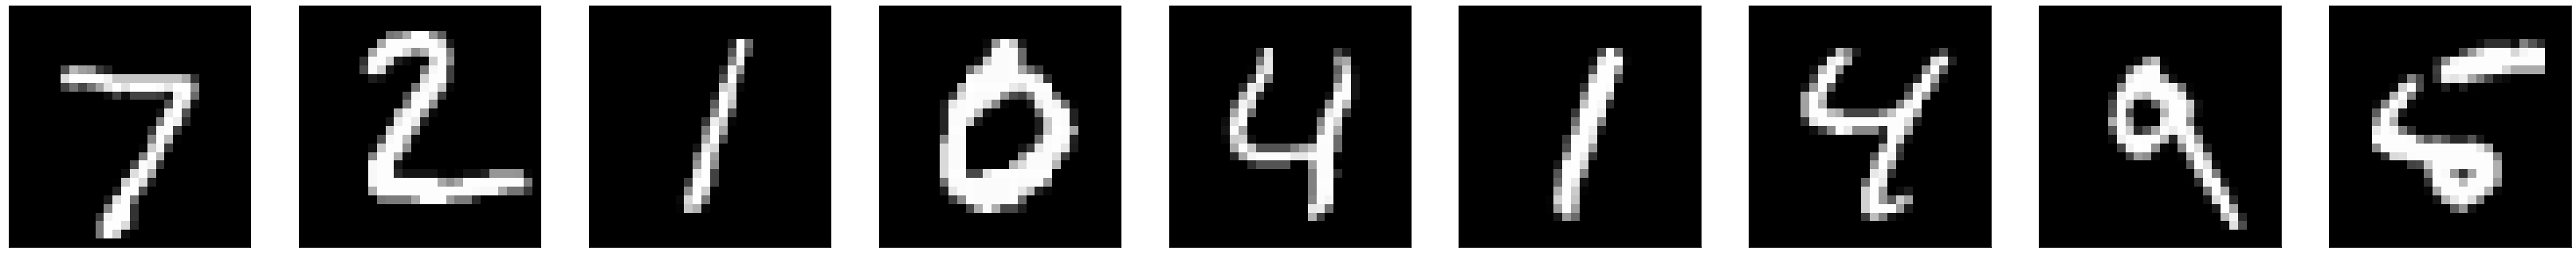

In [6]:
val_samples_imgs = (val_samples.numpy() + 1.) / 2
val_samples_imgs = np.tile(val_samples_imgs, (1, 1, 1, 3))

figure = plot_image_grid([val_samples_imgs], grayscale=True, transpose=True)


In [7]:
# Network hyper-parameters:
kernel_size       = 4
noise_dim         = 2
filters_orig_gen  = 64
layer_depth_gen   = 3
filters_orig_disc = 64
layer_depth_disc  = 3

In [8]:
# c.f. DAE architecture in Chapter 6, Notebook 3
def simple_encoder(input_shape, latent_dim=32, 
                   kernel_size=4, filters_orig=32, layer_depth=4,
                   final_activation=None, name='encoder'):
    """
    Build a simple encoder network.
    :param input_shape:      Shape of the input image (H x W x C)
    :param latent_dim:       Size of the latent space
    :param kernel_size:      Kernel size for the convolutions
    :param filters_orig:     Number of filters for the 1st CNN layer (then multiplied by 2 each layer)
    :param layer_depth:      Number of layers composing the encoder/decoder
    :param final_activation: Activation function for the last layer
    :param name:             Model name
    :return:                 Encoder model
    """
    
    layers = []
    layers += [
        # Taking images as inputs:
        InputLayer(input_shape=input_shape)
    ]
    for i in range(layer_depth):
        # Adding conv layers to extract features:
        layers += [
            Conv2D(filters=min(filters_orig * (2 ** i), 512),
                   kernel_size=kernel_size, activation=None, strides=2, 
                   padding='same'),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.3)
        ]
    layers += [
        # Flattening feature vectors and outputting result vector:
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(latent_dim, activation=final_activation)
    ]
    
    return Sequential(layers, name=name)
    
def simple_decoder(output_shape, latent_dim=32, 
                   kernel_size=4, filters_orig=32, layer_depth=4,
                   final_activation=None, name='decoder'):
    """
    Build a simple decoder network.
    :param output_shape:     Shape of the output image (H x W x C)
    :param latent_dim:       Size of the latent space
    :param kernel_size:      Kernel size for the convolutions
    :param filters_orig:     Number of filters for the 1st CNN layer (then multiplied by 2 each layer)
    :param layer_depth:      Number of layers composing the encoder/decoder
    :param final_activation: Activation function for the last layer
    :param name:             Model name
    :return:                 Decoder model
    """
    
    # c.f. Chapter 6, Notebook 3
    ResizeToOutputShapeLayer = lambda name: Lambda(
            lambda images: tf.image.resize(images, output_shape[:2]), name=name)
    
    divided_size = np.ceil(np.asarray(output_shape[:2]) / (2 ** layer_depth)).astype(np.int32)
    filters = filters_orig * (2 ** layer_depth)
    
    layers = []
    layers += [
        # Taking codes from the latent space as inputs:
        InputLayer(input_shape=(latent_dim,)),
        # Extending and reshaping into a 2D feature map:
        Dense(units=divided_size[0] * divided_size[1] * filters, activation=None),
        BatchNormalization(),
        Activation('relu'), # LeakyReLU(),
        Reshape(target_shape=(*divided_size, filters)),
        Dropout(0.3)
    ]
    for i in range(layer_depth):
        # Upsampling/convolving to decode into an image:
        layers += [
            Conv2DTranspose(filters=min(filters_orig * (2 ** (layer_depth - i - 1)), 512), 
                            kernel_size=kernel_size, activation=None, strides=2, 
                            padding='same'),
            BatchNormalization(),
            Activation('relu') # LeakyReLU()
        ]
    
    layers += [
        # Making sure to get back the original dimensions:
        ResizeToOutputShapeLayer('resize_to_orig'),
        # Decoding and outputting the image:
        Conv2DTranspose(filters=input_shape[-1], kernel_size=kernel_size, 
                        activation=final_activation,
                        strides=1, padding='same')
    ]
    
    return Sequential(layers, name=name)

In [9]:
# Generator (transforming a noise vector of shape `(laten_dim,)`
# into an image of shape `(img_row, img_col, img_ch)`:
generator = simple_decoder(input_shape, noise_dim, kernel_size,
                           filters_orig_gen, layer_depth_gen, 'tanh', 'generator')
generator.summary()

# Discriminator performing a binary classification, judging if
# images are real or fake (i.e., 2 classes):
discriminator = simple_encoder(input_shape, 2, kernel_size, 
                               filters_orig_disc, layer_depth_disc, None, 'discriminator')
discriminator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              24576     
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
activation (Activation)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         2097408   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         10

###  Training and Testing a GAN

In [10]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.SGD()

In [11]:
@tf.function
def gan_train_step(image_batch):
    """
    Perform one training step for the GAN model.
    :param image_batch:     Batch of real training images
    :return:                Loss of the generator, Loss of the discriminator
    """

    batch_size  = tf.shape(image_batch)[0]
    
    real_images = image_batch
    real_labels = tf.ones((batch_size,))
    fake_labels = tf.zeros((batch_size,))
    all_labels  = tf.concat((real_labels, fake_labels), axis=0)
    
    z_noise = tf.random.normal((batch_size, noise_dim))
    with tf.GradientTape() as discriminator_tape, tf.GradientTape() as generator_tape:
        # Generating fake images:
        fake_images = generator(z_noise, training=True)
    
        # Classifying real/fake images:
        pred_labels_on_real = discriminator(real_images, training=True)
        pred_labels_on_fake = discriminator(fake_images, training=True)

        pred_labels_on_all = tf.concat((pred_labels_on_real, pred_labels_on_fake), axis=0)
    
        # Computing the losses:
        discriminator_loss = loss(all_labels, pred_labels_on_all)
        generator_loss = loss(real_labels, pred_labels_on_fake)
        
    
    # Finally, back-propagating the gradients into both networks:
    discriminator_grad = discriminator_tape.gradient(discriminator_loss, 
                                                     discriminator.trainable_variables)
    generator_grad = generator_tape.gradient(generator_loss, 
                                             generator.trainable_variables)
    discriminator_optimizer.apply_gradients(
        zip(discriminator_grad, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(
        zip(generator_grad, generator.trainable_variables))
    
    return generator_loss, discriminator_loss


@tf.function
def gan_val_step(image_batch):

    batch_size  = tf.shape(image_batch)[0]
    
    real_images = image_batch
    real_labels = tf.ones((batch_size,))
    fake_labels = tf.zeros((batch_size,))
    all_labels  = tf.concat((real_labels, fake_labels), axis=0)
    
    z_noise = tf.random.normal((batch_size, noise_dim))
    
    # Generating fake images:
    fake_images = generator(z_noise, training=False)
    
    # Classifying real/fake images:
    pred_labels_on_real = discriminator(real_images, training=False)
    pred_labels_on_fake = discriminator(fake_images, training=False)
    
    pred_labels_on_all = tf.concat((pred_labels_on_real, pred_labels_on_fake), axis=0)
    
    # Computing the losses:
    discriminator_loss = loss(all_labels, pred_labels_on_all)
    generator_loss = loss(real_labels, pred_labels_on_fake)
    
    return generator_loss, discriminator_loss

In [12]:
model_name = 'mnist_gan'
model_dir = os.path.join('models', model_name)

# Callback to postprocess some validation results and display them in Tensorboard:
# Fixed noise vectors to generate images from:
z_noise_samples = tf.random.normal((num_show, noise_dim))

# Function to post-process the results, i.e. to convert noise vectors in images before plotting
def process_images_before_plot(input_z, pred_imgs, target_imgs=None):
    # Transforming noise vectors into plottable images:
    noise_min, noise_max = tf.reduce_min(input_z), tf.reduce_max(input_z)
    input_z = (input_z - noise_min) / (noise_max - noise_min)
    input_z_imgs = np.tile(np.expand_dims(np.expand_dims(input_z, 1), -1), 
                           (1, 2, 1, 3))
    # Normalizing generated images from [-1, 1] to [0, 1] and tiling channels:
    pred_imgs = (pred_imgs + 1.) / 2
    pred_imgs = np.tile(pred_imgs, (1, 1, 1, 3))

    return input_z_imgs, pred_imgs, target_imgs

callback_tb_grid = TensorBoardImageGridCallback(
    log_dir=model_dir, preprocess_fn=process_images_before_plot,
    input_images=z_noise_samples, target_images=None, 
    grayscale=True, transpose=True,
    tag=model_name + '_results', figsize=(15, 15))

# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
metrics_to_print = collections.OrderedDict([("g_loss", "g_loss"), 
                                            ("d_loss", "d_loss"),
                                            ("val_g_loss", "val_g_loss"), 
                                            ("val_d_loss", "val_d_loss")])
callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=2)


callback_tb_grid.set_model(generator)
custom_callbacks = [callback_simple_log, callback_tb_grid]

<Figure size 4500x4500 with 0 Axes>

In [13]:
def loop_for_epoch(step_fn, dataset_iter, train_steps_per_epoch,
                   generator_loss_accumulator, discriminator_loss_accumulator):
    for i in range(train_steps_per_epoch):
        batch = next(dataset_iter)
        generator_loss, discriminator_loss = step_fn(batch)
        generator_loss_accumulator.update_state(generator_loss)
        discriminator_loss_accumulator.update_state(discriminator_loss)
    
    # End of training epoch:
    accumulated_generator_loss = generator_loss_accumulator.result()
    accumulated_discriminator_loss = discriminator_loss_accumulator.result()
    tf.summary.scalar('gen_loss', accumulated_generator_loss, 
                      step=generator_optimizer.iterations)
    tf.summary.scalar('disc_loss', accumulated_discriminator_loss, 
                      step=discriminator_optimizer.iterations)
    generator_loss_accumulator.reset_states()
    discriminator_loss_accumulator.reset_states()
    return accumulated_generator_loss.numpy(), accumulated_discriminator_loss.numpy()


def train(train_dataset, epochs, train_steps_per_epoch,
          val_dataset=None, val_steps_per_epoch=None,
          summary_dir='./summaries', callbacks=[]):  
    
    train_summary_writer = tf.summary.create_file_writer(
        os.path.join(summary_dir, 'train'))
    if val_dataset is not None:
        val_summary_writer = tf.summary.create_file_writer(
            os.path.join(summary_dir, 'val'))
    avg_generator_loss = tf.keras.metrics.Mean(name='avg_gen_loss', dtype=tf.float32)
    avg_discriminator_loss = tf.keras.metrics.Mean(name='avg_disc_loss', dtype=tf.float32)
    
    for cb in custom_callbacks:
        cb.on_train_begin()
        
    train_dataset_iter = train_dataset.__iter__()
    for epoch in range(epochs):
        with train_summary_writer.as_default():
            g_train_loss, d_train_loss = loop_for_epoch(
                gan_train_step, train_dataset_iter, train_steps_per_epoch,
                avg_generator_loss, avg_discriminator_loss)

        if val_dataset is not None:
            val_dataset_iter = val_dataset.__iter__()
            with val_summary_writer.as_default():
                g_val_loss, d_val_loss = loop_for_epoch(
                    gan_val_step, val_dataset_iter, val_steps_per_epoch,
                    avg_generator_loss, avg_discriminator_loss)
        else: 
            g_val_loss, d_val_loss = np.nan, np.nan
        
        logs = {'g_loss': g_train_loss, 'd_loss': d_train_loss,
                'val_g_loss': g_val_loss, 'val_d_loss': d_val_loss}
        for cb in custom_callbacks:
            cb.on_epoch_end(epoch, logs)
                    
    for cb in custom_callbacks:
        cb.on_train_end()

In [14]:
train(train_dataset=train_dataset, epochs=num_epochs, 
      train_steps_per_epoch=train_steps_per_epoch,
      val_dataset=val_dataset, val_steps_per_epoch=val_steps_per_epoch,
      summary_dir=os.path.join(model_dir, 'summaries'), callbacks=custom_callbacks)

Training: start.
Epoch  1/31: g_loss = 3.739; d_loss = 0.324; val_g_loss = 2.267; val_d_loss = 0.536
Epoch  3/31: g_loss = 6.606; d_loss = 0.128; val_g_loss = 4.632; val_d_loss = 0.005
Epoch  5/31: g_loss = 9.765; d_loss = 0.000; val_g_loss = 4.858; val_d_loss = 0.004
Epoch  7/31: g_loss = 11.157; d_loss = 0.000; val_g_loss = 5.184; val_d_loss = 0.003
Epoch  9/31: g_loss = 11.665; d_loss = 0.000; val_g_loss = 5.272; val_d_loss = 0.003
Epoch 11/31: g_loss = 11.948; d_loss = 0.000; val_g_loss = 5.310; val_d_loss = 0.003
Epoch 13/31: g_loss = 4.594; d_loss = 0.192; val_g_loss = 2.246; val_d_loss = 0.283
Epoch 15/31: g_loss = 5.058; d_loss = 0.168; val_g_loss = 7.730; val_d_loss = 0.222
Epoch 17/31: g_loss = 5.760; d_loss = 0.210; val_g_loss = 0.004; val_d_loss = 4.941
Epoch 19/31: g_loss = 3.333; d_loss = 0.315; val_g_loss = 2.772; val_d_loss = 0.158
Epoch 21/31: g_loss = 3.060; d_loss = 0.298; val_g_loss = 0.708; val_d_loss = 0.525
Epoch 23/31: g_loss = 2.663; d_loss = 0.400; val_g_loss 

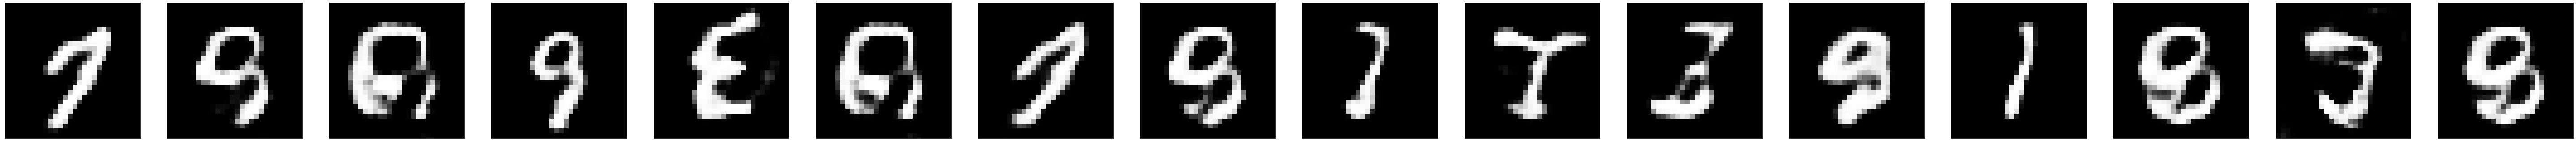

In [16]:
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, noise_dim])
images = generator(random_vector_for_generation)

images = (images + 1.) / 2
images = np.tile(images, (1, 1, 1, 3))

figure = plot_image_grid([images], grayscale=True, transpose=True)

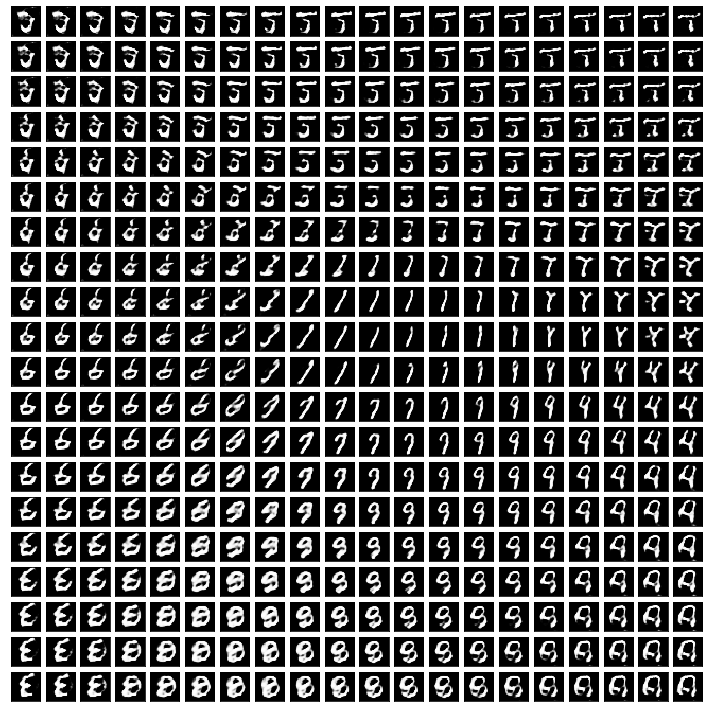

In [18]:
# We built a 2D latent space, so let us explore it.

dim1_num, dim2_num = 20, 20
dim1_grid = np.linspace(-1.5, 1.5, dim1_num)
dim2_grid = np.linspace(-1.5, 1.5, dim2_num)

z_samples = []
for dim1_val in dim1_grid:
    for dim2_val in dim2_grid:
        z_sample = np.array([dim1_val, dim2_val])
        z_samples.append(z_sample)

z_samples = np.stack(z_samples, axis=0)
images = generator.predict(z_samples) 
images = (images + 1.) / 2
images = np.tile(images, (1, 1, 1, 3))
images = np.reshape(images, (dim1_num, dim2_num, img_rows, img_cols, 3))
   
figure = plot_image_grid(images, 
                         figure=plt.figure(figsize=(10, 10)),
                         grayscale=True)

В итоге генератор научился генерировать похожие на цифры изображения, при этом не обучаясь на реальных изображениях